In [ ]:
import time

from tracking import accuracy, Accumulator, Animator

tmetrics = [(1.0274171930678346, 0.6658964982269504, 0.763),
 (0.5703624746900924, 0.8148492907801419, 0.8122),
 (0.49420703763657425, 0.8389627659574468, 0.8231),
 (0.46455995186846305, 0.8478945035460993, 0.8285),
 (0.4665593981742859, 0.8460328014184397, 0.8303),
 (0.47631714077706033, 0.8426806294326241, 0.7724),
 (0.47873934101551135, 0.8446919326241135, 0.8274),
 (0.4705558104717985, 0.8460272606382979, 0.836),
 (0.4501812088996806, 0.8542664007092198, 0.8071),
 (0.4470973132772649, 0.8561336436170213, 0.8503)]

animator = Animator(xlabel='epoch', xlim=[1, 10], ylim=[0.4, 0.9], legend=['train loss', 'train acc', 'test acc'])

for i in range(10):
    x, y, z = tmetrics[i]
    time.sleep(1)
    animator.add(i + 1, (x, y, z))

## Notebook Set Up

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

## Standard Imports

In [2]:
%matplotlib inline
import d2l
d2l.use_svg_display()
import jax
from jax import numpy as jnp, random
import numpy as np
import optax
#from tqdm import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()
print("Using jax", jax.__version__)
print("Optax Version : {}".format(optax.__version__))
devices = jax.local_devices()
print(f"Found {len(devices)} devices.")
devices[0]

Using jax 0.3.13
Optax Version : 0.1.2
Found 8 devices.


TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)

## Data

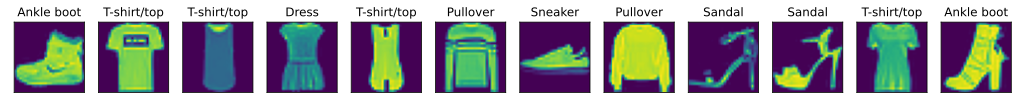

In [4]:
from fashion_mnist import load_data

X_train, X_test, Y_train, Y_test, classes, mapping = load_data()
batch_size = 256

images = X_train[:12]
titles = [mapping[y] for y in Y_train[:12]]
d2l.show_images(images.reshape((12, 28, 28)), 1, 12, titles=titles);

## Model

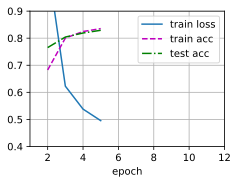

In [ ]:
from data import DataLoader
from flax import linen as nn
from jax import value_and_grad
from sklearn.metrics import accuracy_score

def CrossEntropyLoss(weights, input_data, actual):
    logits = model.apply(weights, input_data)
    one_hot_actual = jax.nn.one_hot(actual, num_classes=len(classes))
    return optax.softmax_cross_entropy(logits, one_hot_actual).mean()


def TrainModelInBatches(X, Y, X_val, Y_val, epochs, weights, optimizer_state, batch_size=32):
    animator = Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0.4, 0.9], legend=['train loss', 'train acc', 'test acc'])
    for i in range(1, epochs + 1):
        losses = []
        accs = []
        dl = DataLoader(X, Y, batch_size)
        for X_batch, Y_batch in dl:
                loss, gradients = value_and_grad(CrossEntropyLoss)(weights, X_batch,Y_batch)
                updates, optimizer_state = optimizer.update(gradients, optimizer_state)
                weights = optax.apply_updates(weights, updates)
                logits = model.apply(weights, X_batch)
                acc = accuracy(logits, Y_batch)
                accs.append(acc)
                losses.append(loss) ## Record Loss
        loss = jnp.array(losses).mean()
        acc = jnp.array(accs).mean()
        preds = model.apply(weights, X_val)
        val_acc = accuracy_score(Y_val, jnp.argmax(preds, axis=1))
        animator.add(i + 1, (loss, acc, val_acc))
    return weights


class Net(nn.Module):

  @nn.compact
  def __call__(self, inputs):
    x = inputs.reshape((-1, 784,))
    x = nn.Dense(256, name='ll1')(x)
    x = nn.relu(x)
    x = nn.Dense(10, name='ll2')(x)
    return x


seed = random.PRNGKey(0)
batch_size=256
epochs=12
learning_rate = jnp.array(1/1e4)

model = Net()
weights = model.init(seed, X_train[:5])

optimizer = optax.adam(learning_rate=learning_rate) ## Initialize SGD Optimizer
optimizer_state = optimizer.init(weights)

weights = TrainModelInBatches(X_train, Y_train, X_test, Y_test, epochs, weights, optimizer_state, batch_size=batch_size)

preds = model.apply(weights, X_test)
acc = accuracy_score(Y_test, jnp.argmax(preds, axis=1))
print("Test  Accuracy : {:.3f}".format(acc))

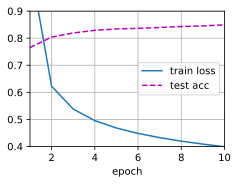

In [11]:
import time

from tracking import accuracy, Accumulator, Animator


animator = Animator(xlabel='epoch', xlim=[1, 10], ylim=[0.4, 0.9], legend=['train loss', 'test acc'])

for i in range(10):
    x, y = losses[i], val_accs[i]
    time.sleep(1)
    animator.add(i + 1, (x, y))
    
    

In [ ]:
from data import DataLoader
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn


class Net(nn.Module):

  @nn.compact
  def __call__(self, inputs):
    x = inputs.reshape((-1, 784,))
    x = nn.Dense(256, name='ll1')(x)
    x = nn.relu(x)
    x = nn.Dense(10, name='ll2')(x)
    return x


key = random.PRNGKey(0)
key, key_init = random.split(key)

batch_size = 256
train_dl = DataLoader(X_train, Y_train, batch_size)
for X_batch, Y_batch in train_dl: break
    
model = Net()
params = model.init(key_init, X_batch)
y = model.apply(params, X_batch)

print('initialized parameter shapes:\n', jax.tree_map(jnp.shape, unfreeze(params)))
print('output:\n', y.shape)

In [ ]:
from flax import linen
from jax import random

class CNN(linen.Module):
    def setup(self):
        self.conv1 = linen.Conv(features=32, kernel_size=(3,3), padding="SAME", name="CONV1")
        self.conv2 = linen.Conv(features=16, kernel_size=(3,3), padding="SAME", name="CONV2")
        self.linear1 = linen.Dense(len(classes), name="DENSE")

    def __call__(self, inputs):
        x = linen.relu(self.conv1(inputs))
        x = linen.relu(self.conv2(x))

        x = x.reshape((x.shape[0], -1))
        logits = self.linear1(x)

        return logits #linen.softmax(x)
    
    
seed = jax.random.PRNGKey(0)

model = CNN()
params = model.init(seed, X_train[:5])

for layer_params in params["params"].items():
    print("Layer Name : {}".format(layer_params[0]))
    weights, biases = layer_params[1]["kernel"], layer_params[1]["bias"]
    print("\tLayer Weights : {}, Biases : {}".format(weights.shape, biases.shape))

In [ ]:
type(metrics[0][0])

In [ ]:
np_metrics = np.array([(2.3069205284118652, 0.11528147011995316, 0.12610000371932983),
 (2.3052029609680176, 0.13235262036323547, 0.13449999690055847),
 (2.3048763275146484, 0.12705008685588837, 0.11969999969005585),
 (2.3047051429748535, 0.11882757395505905, 0.11420000344514847),
 (2.304596185684204, 0.11496010422706604, 0.11240000277757645),
 (2.304521083831787, 0.11617907881736755, 0.11710000038146973),
 (2.3044638633728027, 0.11771941184997559, 0.11710000038146973),
 (2.3044168949127197, 0.12086103856563568, 0.11900000274181366),
 (2.30437970161438, 0.12367021292448044, 0.12370000034570694),
 (2.3043484687805176, 0.12556515634059906, 0.12200000137090683)], dtype=np.float32)

type(np_metrics[0][0])

In [ ]:
import time

#np_metrics = [(float(x), float(y), float(z)) for x, y, z in np.array(metrics, dtype=np.float32)]
animator = Animator(xlabel='epoch', xlim=[1, 10], ylim=[0.4, 0.9], legend=['train loss', 'train acc', 'test acc'])
i = 0
for x, y, z in np_metrics:
    i += 1
    time.sleep(1)
    animator.add(i + 1, (x, y, z))

In [ ]:
[
    (x, y, z) for x, y, z in metrics
]

test_accuracy

In [ ]:
metrics

animator = Animator(xlabel='epoch', xlim=[1, 10], ylim=[0.4, 0.9], legend=['train loss', 'train acc', 'test acc'])

for i in range(10):
    time.sleep(1)
    a, b, c = metrics[i]
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    animator.add(i + 1, (a, b, c))

In [ ]:
x = [1.075, 0.621, 0.533, 0.490, 0.463, 0.443, 0.428, 0.416, 0.405, 0.396]
type(x[0])

In [ ]:
import time
x = [1.075, 0.621, 0.533, 0.490, 0.463, 0.443, 0.428, 0.416, 0.405, 0.396]
y = [0.691, 0.801, 0.825, 0.837, 0.845, 0.851, 0.855, 0.859, 0.862, 0.865]
z = [0.767, 0.805, 0.821, 0.828, 0.832, 0.839, 0.842, 0.844, 0.846, 0.848]
animator = Animator(xlabel='epoch', xlim=[1, 10], ylim=[0.4, 0.9], legend=['train loss', 'train acc', 'test acc'])

for i in range(10):
    time.sleep(1)
    animator.add(i + 1, (x[i], y[i], z[i]))

In [ ]:
type(x[0])

In [ ]:
def cross_entropy_loss(W1, b1, W2, b2, X, Y):
    def pointwise(x, y):
        logits = model.apply(params, x)
        one_hot_y = jax.nn.one_hot(y, num_classes=num_outputs)
        return optax.softmax_cross_entropy(logits, one_hot_y)
    return jnp.mean(jax.vmap(pointwise)(X, Y), axis=0)[0]

def cross_entropy_loss(params, X, Y, num_classes=len(classes)):
    def pointwise(x, y):
        logits = model.apply(params, x)
        one_hot_y = jax.nn.one_hot(y, num_classes=num_outputs)
        return optax.softmax_cross_entropy(logits, one_hot_y)
    return jnp.mean(jax.vmap(pointwise)(X, Y), axis=0)[0]


In [ ]:
model = Net()
weights = model.init(key_init, X_train[:5])
X = X_train[:8]
Y = Y_train[:8]
v = cross_entropy_loss(weights, X, Y, num_classes=len(classes))


In [ ]:
from tracking import accuracy, Accumulator, Animator


logits = model.apply(weights, X)
v = accuracy(logits, Y)
float(v)
type(v)

In [ ]:
from data import DataLoader
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn

from jax import value_and_grad
from sklearn.metrics import accuracy_score
from tracking import accuracy, Accumulator, Animator


def cross_entropy_loss(params, X, Y, num_classes=len(classes)):
    def pointwise(x, y):
        logits = model.apply(params, x)
        one_hot_y = jax.nn.one_hot(y, num_classes==num_classes)
        return optax.softmax_cross_entropy(logits, one_hot_y)
    return jnp.mean(jax.vmap(pointwise)(X, Y), axis=0)[0]



def TrainModelInBatches(X, Y, X_val, Y_val, epochs, weights, optimizer_state, batch_size=32):
    animator = Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0.0, 2], legend=['train loss', 'train acc', 'test acc'])
    results = []
    for i in range(1, epochs + 1):
        metric = Accumulator(3)
        losses = []
        dl = DataLoader(X, Y, batch_size)
        for X_batch, Y_batch in dl:
            loss, gradients = value_and_grad(cross_entropy_loss)(weights, X_batch, Y_batch)
            updates, optimizer_state = optimizer.update(gradients, optimizer_state)
            weights = optax.apply_updates(weights, updates)
            logits = model.apply(weights, X_batch)
            train_accuracy = accuracy(logits, Y_batch)
            metric.add(loss, train_accuracy, 1) # Y_batch.shape[0])
            losses.append(loss)
        train_loss = metric[0] / metric[2]
        train_accuracy = metric[1] / metric[2]
        logits = model.apply(weights, X_val)
        test_accuracy = accuracy(logits, Y_val)
        results.append(test_accuracy)
        animator.add(1, (train_loss, train_accuracy,  test_accuracy))
    return weights, results

class Net(nn.Module):

  @nn.compact
  def __call__(self, inputs):
    x = inputs.reshape((-1, 784,))
    x = nn.Dense(256, name='ll1')(x)
    x = nn.relu(x)
    x = nn.Dense(10, name='ll2')(x)
    return x

batch_size=256
epochs=2
learning_rate = jnp.array(1/1e4)

key = random.PRNGKey(0)
key, key_init = random.split(key)

model = Net()
weights = model.init(key_init, X_train[:5])

optimizer = optax.adam(learning_rate=learning_rate) ## Initialize SGD Optimizer
optimizer_state = optimizer.init(weights)

final_weights, results = TrainModelInBatches(X_train, Y_train, X_test, Y_test, epochs, weights, optimizer_state, batch_size=batch_size)

In [ ]:
results

In [ ]:
from data import DataLoader
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn

from jax import value_and_grad
from sklearn.metrics import accuracy_score
from tracking import accuracy, Accumulator, Animator


def cross_entropy_loss(params, X, Y, num_classes=len(classes)):
    logits = model.apply(params, X)
    one_hot_Y = jax.nn.one_hot(Y, num_classes=num_classes)
    return optax.softmax_cross_entropy(logits, one_hot_Y).mean()


def cross_entropy_loss(params, X, Y, num_classes=len(classes)):
    def pointwise(x, y):
        logits = model.apply(params, x)
        one_hot_y = jax.nn.one_hot(y, num_classes==num_classes)
        return optax.softmax_cross_entropy(logits, one_hot_y)
    return jnp.mean(jax.vmap(pointwise)(X, Y), axis=0)[0]



def TrainModelInBatches(X, Y, X_val, Y_val, epochs, weights, optimizer_state, batch_size=32):
    metrics = []
    x = [1.075, 0.621, 0.533, 0.490, 0.463, 0.443, 0.428, 0.416, 0.405, 0.396]
    y = [0.691, 0.801, 0.825, 0.837, 0.845, 0.851, 0.855, 0.859, 0.862, 0.865]
    z = [0.767, 0.805, 0.821, 0.828, 0.832, 0.839, 0.842, 0.844, 0.846, 0.848]
    animator = Animator(xlabel='epoch', xlim=[1, 10], ylim=[0.4, 0.9], legend=['train loss', 'train acc', 'test acc'])
    #animator = Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0.0, 1.0], legend=['train loss', 'train acc', 'test acc'])
    for i in range(1, epochs + 1):
        metric = Accumulator(3)
        losses = []
        accuracies = []
        dl = DataLoader(X, Y, batch_size)
        for X_batch, Y_batch in dl:
            loss, gradients = value_and_grad(cross_entropy_loss)(weights, X_batch, Y_batch)
            updates, optimizer_state = optimizer.update(gradients, optimizer_state)
            weights = optax.apply_updates(weights, updates)
            logits = model.apply(weights, X_batch)
            train_accuracy = accuracy(logits, Y_batch)
            train_accuracy = np.float32(train_accuracy)
            accuracies.append()
            loss = np.float32(loss)
            losses.append(float(jax.device_get(loss)))
        train_loss = np.array(losses).mean()
        train_accuracy = np.array(accuracies).mean()
        #print("Train Loss : {:.3f}".format(jnp.array(losses).mean()))
        #print("Train Accuracy : {:.3f}".format(jnp.array(accuracies).mean()))
        logits = model.apply(weights, X_val)
        test_accuracy = accuracy(logits, Y_val)
        train_accuracy = np.float32(test_accuracy)
        #print("Test  Accuracy : {:.3f}".format(test_accuracy))
        metrics.append((train_loss, train_accuracy, test_accuracy))
        animator.add(1, (x[i - 1], y[i - 1],  z[i - 1]))
    return weights, metrics

class Net(nn.Module):

  @nn.compact
  def __call__(self, inputs):
    x = inputs.reshape((-1, 784,))
    x = nn.Dense(256, name='ll1')(x)
    x = nn.relu(x)
    x = nn.Dense(10, name='ll2')(x)
    return x

batch_size=256
epochs=10
learning_rate = jnp.array(1/1e4)

key = random.PRNGKey(0)
key, key_init = random.split(key)

model = Net()
weights = model.init(key_init, X_train[:5])

optimizer = optax.adam(learning_rate=learning_rate) ## Initialize SGD Optimizer
optimizer_state = optimizer.init(weights)

final_weights, metrics = TrainModelInBatches(X_train, Y_train, X_test, Y_test, epochs, weights, optimizer_state, batch_size=batch_size)


In [ ]:
x, y, z = metrics[0]
type(x), type(y), type(z)

In [ ]:
x = [1.075, 0.621, 0.533, 0.490, 0.463, 0.443, 0.428, 0.416, 0.405, 0.396]
y = [0.691, 0.801, 0.825, 0.837, 0.845, 0.851, 0.855, 0.859, 0.862, 0.865]
z = [0.767, 0.805, 0.821, 0.828, 0.832, 0.839, 0.842, 0.844, 0.846, 0.848]

## Loss Function

In [ ]:
def cross_entropy_loss(params, X, Y, num_classes=len(classes)):
    logits = model.apply(params, X)
    one_hot_Y = jax.nn.one_hot(Y, num_classes)
    return optax.softmax_cross_entropy(logits, one_hot_Y).sum()

## Train

In [ ]:
from tracking import accuracy, Accumulator, Animator


@jax.jit
def update(params, X_batch, Y_batch, optimizer_state):    
    loss, gradients = jax.value_and_grad(cross_entropy_loss)(params, X_batch, Y_batch)
    updates, optimizer_state = optimizer.update(gradients, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, loss, optimizer_state


def train_epoch(dl, params, optimizer_state):
    metric = Accumulator(3)
    for X_batch, Y_batch in dl:  
        params, loss, optimizer_state = update(params, X_batch, Y_batch, optimizer_state)
        logits = model.apply(params, X_batch)
        metric.add(loss, accuracy(logits, Y_batch), 1) # Y_batch.shape[0])
    average_loss = metric[0] / metric[2]
    average_accuracy = metric[1] / metric[2]
    return average_loss, average_accuracy, params, optimizer_state


def train(params, X_train, X_test, Y_train, Y_test, num_epochs, batch_size, optimizer_state):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0], legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        dl = DataLoader(X_train, Y_train, batch_size)
        train_loss, train_accuracy, params, optimizer_state = train_epoch(dl, params, optimizer_state)
        logits = model.apply(params, X_test)
        test_accuracy = accuracy(logits, Y_test)
        animator.add(epoch + 1, (train_loss, train_accuracy, test_accuracy))
    return params

epochs = 3
learning_rate = 0.0001

optimizer = optax.adam(learning_rate=learning_rate)
optimizer_state = optimizer.init(params)
params = train(params, X_train, X_test, Y_train, Y_test, epochs, batch_size, optimizer_state);